In [1]:
%matplotlib notebook

In [2]:
import tensorflow as tf
import librosa
import librosa.display
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# Loading Music

In [3]:
CONTENT_FILENAME = "inputs/treasure_10.mp3"
STYLE_FILENAME = "inputs/g_and_g_10s.mp3"

In [4]:
print("CONTENT_FILENAME: {}".format(CONTENT_FILENAME))
display(Audio(CONTENT_FILENAME))
print("STYLE_FILENAME: {}".format(STYLE_FILENAME))
display(Audio(STYLE_FILENAME))

CONTENT_FILENAME: inputs/treasure_10.mp3


STYLE_FILENAME: inputs/g_and_g_10s.mp3


# Example Codes with Librosa

Example code from: 
https://librosa.github.io/librosa/tutorial.html

https://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb

https://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20audio%20effects%20and%20playback.ipynb

In [5]:
# Beat tracking example
from __future__ import print_function
import librosa

# 1. Get the file path to the included audio example
filename = librosa.util.example_audio_file()

# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y, sr = librosa.load(filename)
print("Sampling rate: {}".format(sr))

# 3. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

print('Saving output to beat_times.csv')
librosa.output.times_csv('beat_times.csv', beat_times)


Sampling rate: 22050
Estimated tempo: 129.20 beats per minute
Saving output to beat_times.csv


## Load audio file in librosa

In [6]:
# By default, librosa will resample the signal to 22050Hz.
y, sr = librosa.load(STYLE_FILENAME, sr=None)
sr

44100

In [7]:
# y, sr = librosa.load(CONTENT_FILENAME, sr=None)
# sr

In [8]:
y.shape

(441000,)

In [9]:
display(Audio(data=y, rate=sr))

## Mel Spectogram

<IPython.core.display.Javascript object>


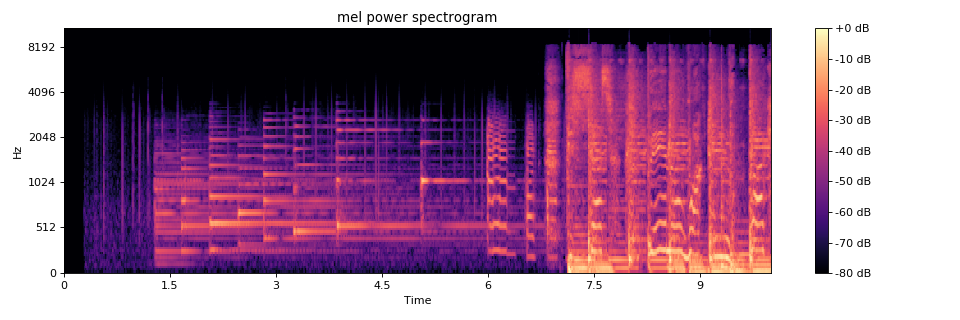

In [10]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

## Harmonic-percussive source separation

In [11]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

<IPython.core.display.Javascript object>


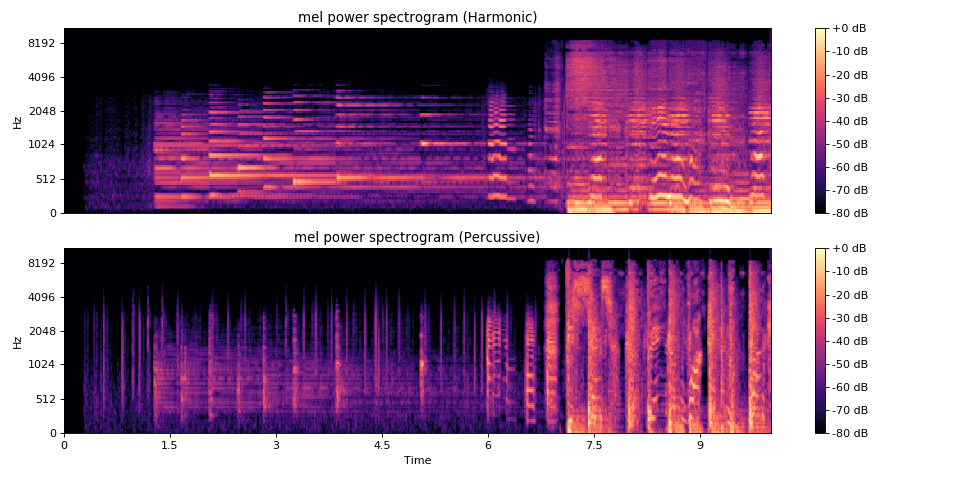

In [12]:
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

In [13]:
log_Sp.shape

(128, 862)

## Chromagram

Next, we'll extract Chroma features to represent pitch class information.


<IPython.core.display.Javascript object>


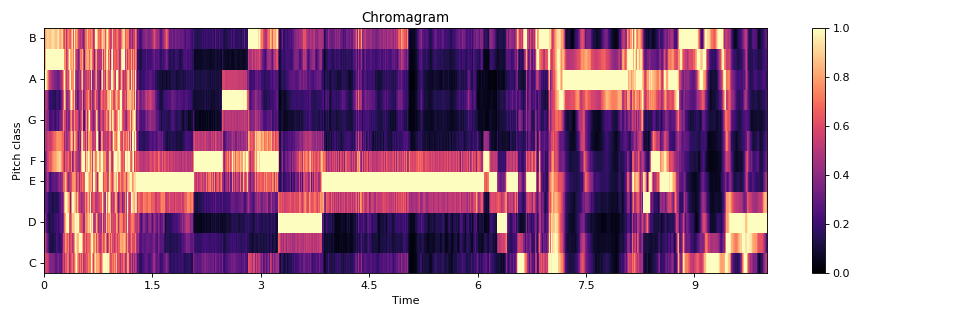

In [14]:


# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()




## MFCC

Mel-frequency cepstral coefficients are commonly used to represent texture or timbre of sound.


<IPython.core.display.Javascript object>


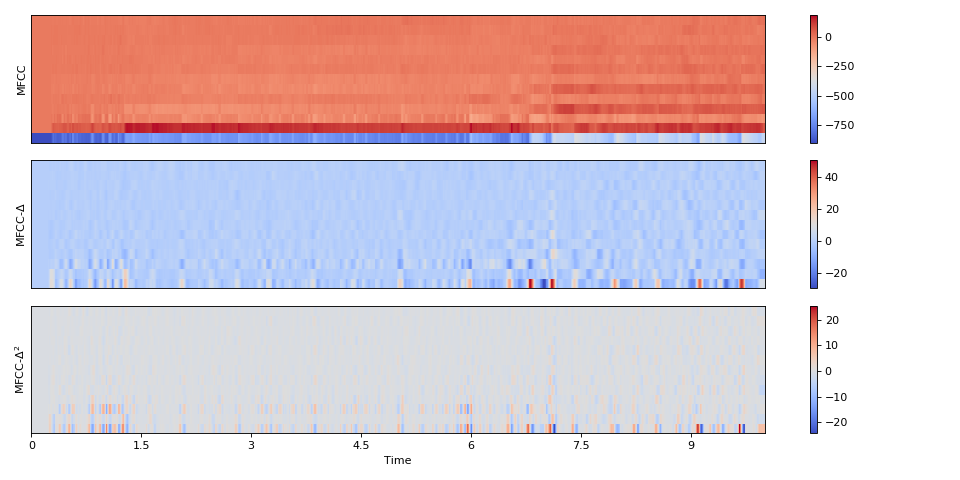

In [15]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

## Beat tracking

The beat tracker returns an estimate of the tempo (in beats per minute) and frame indices of beat events.

The input can be either an audio time series (as we do below), or an onset strength envelope as calculated by librosa.onset.onset_strength()

<IPython.core.display.Javascript object>


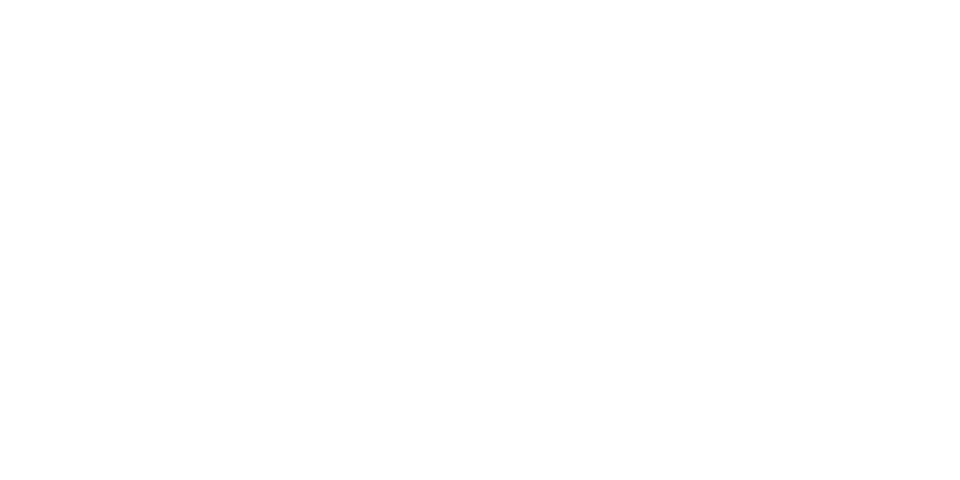

<IPython.core.display.Javascript object>


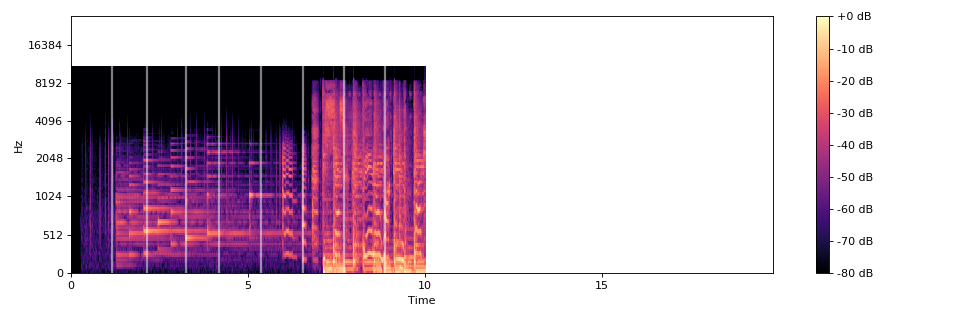

In [16]:
# Now, let's run the beat tracker.
# We'll use the percussive component for this part
plt.figure(figsize=(12, 6))
tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)

# Let's re-draw the spectrogram, but this time, overlay the detected beats
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(beats),
           1, 0.5 * sr,
           colors='w', linestyles='-', linewidth=2, alpha=0.5)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()



By default, the beat tracker will trim away any leading or trailing beats that don't appear strong enough.

To disable this behavior, call beat_track() with trim=False.


In [17]:
print('Estimated tempo:        %.2f BPM' % tempo)

print('First 5 beat frames:   ', beats[:5])

# Frame numbers are great and all, but when do those beats occur?
print('First 5 beat times:    ', librosa.frames_to_time(beats[:5], sr=sr))

# We could also get frame numbers from times by librosa.time_to_frames()

Estimated tempo:        105.47 BPM
First 5 beat frames:    [ 50  93 140 180 231]
First 5 beat times:     [0.58049887 1.07972789 1.62539683 2.08979592 2.68190476]



## Beat-synchronous feature aggregation

Once we've located the beat events, we can use them to summarize the feature content of each beat.

This can be useful for reducing data dimensionality, and removing transient noise from the features.


<IPython.core.display.Javascript object>


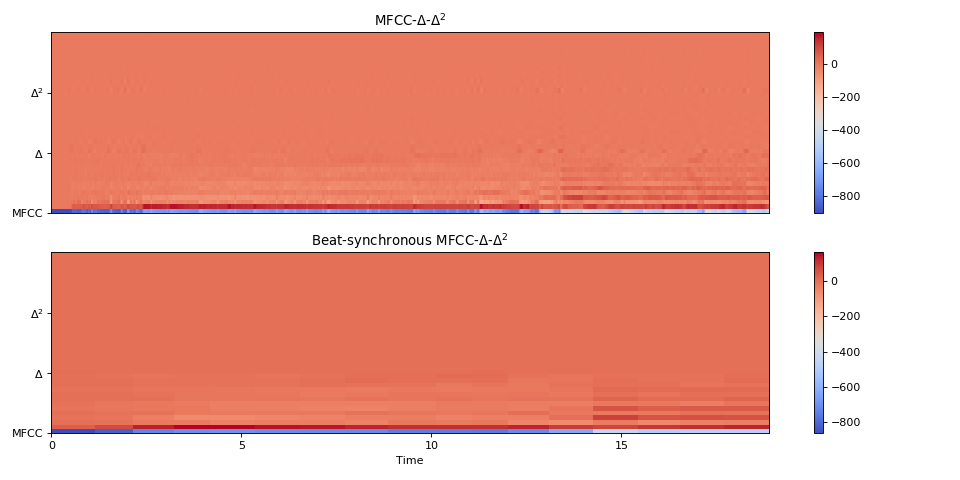

In [18]:
# feature.sync will summarize each beat event by the mean feature vector within that beat

M_sync = librosa.util.sync(M, beats)

plt.figure(figsize=(12,6))

# Let's plot the original and beat-synchronous features against each other
plt.subplot(2,1,1)
librosa.display.specshow(M)
plt.title('MFCC-$\Delta$-$\Delta^2$')

# We can also use pyplot *ticks directly
# Let's mark off the raw MFCC and the delta features
plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

plt.colorbar()

plt.subplot(2,1,2)
# librosa can generate axis ticks from arbitrary timestamps and beat events also
librosa.display.specshow(M_sync, x_axis='time',
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

## Spectogram

In [19]:
# How about something more advanced?  Let's decompose a spectrogram with NMF, and then resynthesize an individual component
D = librosa.stft(y)

# Separate the magnitude and phase
S, phase = librosa.magphase(D)

# Decompose by nmf
components, activations = librosa.decompose.decompose(S, n_components=8, sort=True)


<IPython.core.display.Javascript object>


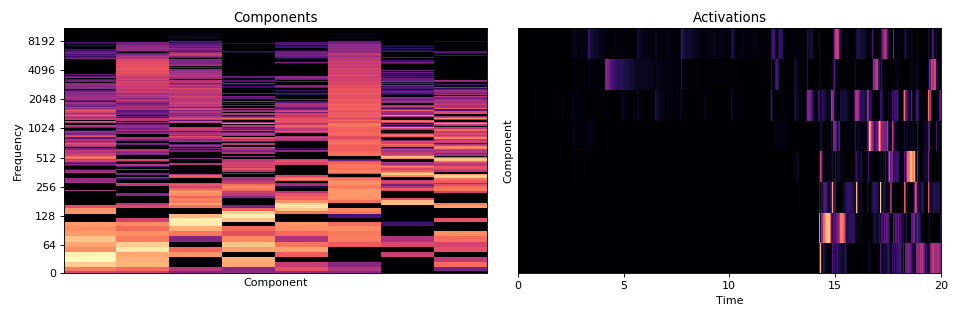

In [20]:


# Visualize the components and activations, just for fun

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(components), ref=np.max), y_axis='log')
plt.xlabel('Component')
plt.ylabel('Frequency')
plt.title('Components')

plt.subplot(1,2,2)
librosa.display.specshow(activations, x_axis='time')
plt.xlabel('Time')
plt.ylabel('Component')
plt.title('Activations')

plt.tight_layout()



In [21]:
print(components.shape, activations.shape)

(1025, 8) (8, 862)


In [22]:
phase.shape

(1025, 862)

In [23]:


# Play back the reconstruction
# Reconstruct a spectrogram by the outer product of component k and its activation
D_k = components.dot(activations)

# invert the stft after putting the phase back in
y_k = librosa.istft(D_k * phase)

# And playback
print('Full reconstruction')

display(Audio(data=y_k, rate=sr))



Full reconstruction


## ifGRAM
Compute the instantaneous frequency (as a proportion of the sampling rate) obtained as the time-derivative of the phase of the complex spectrum as described by [1].

Calculates regular STFT as a side effect.

In [24]:
frequencies, D = librosa.ifgram(y, sr=sr)
frequencies.shape

(1025, 862)

<IPython.core.display.Javascript object>


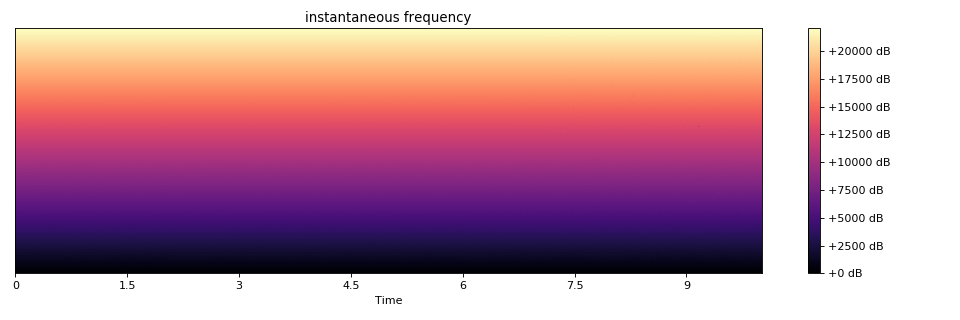

In [25]:

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
#librosa.display.specshow(frequencies, sr=sr, x_axis='time', y_axis='frequencies')
#plt.title('Content')
#plt.imshow(frequencies)
librosa.display.specshow(frequencies,sr=sr, x_axis='time')


# Put a descriptive title on the plot
plt.title('instantaneous frequency')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()